In [6]:
!pip install yfinance 
!pip install xgboost


Error processing line 7 of C:\Users\118201\AppData\Local\Continuum\anaconda3\lib\site-packages\pywin32.pth:

  Traceback (most recent call last):
    File "C:\Users\118201\AppData\Local\Continuum\anaconda3\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  ModuleNotFoundError: No module named 'pywin32_bootstrap'

Remainder of file ignored


In [10]:
import yfinance as yf
import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

date = datetime.date.today()
today = str(date)
start_years = str(date.today() + relativedelta(years=-20))
stock_list = ['^GSPC', '^VIX']

# 抓取20年資料
df = yf.download(stock_list[0], start = start_years, end = today).drop(columns='Adj Close')
vix = yf.download(stock_list[1], start = start_years, end = today)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
df['VIX']=vix['Close']
df['MA10']=df['Close'].rolling(10,min_periods=1).mean()
df['MA60']=df['Close'].rolling(60,min_periods=1).mean()
df['Daily Return'] = df['Close'].pct_change()
df['std'] = df['Daily Return'].rolling(20,min_periods=1).std()
df['5d'] = df['Daily Return'].rolling(5,min_periods=1).sum()
df['VixMA']=df["VIX"].rolling(10,min_periods=1).mean()
df['VIXDiffer']=df['VIX']-df['VixMA']
df['diff']=df['Daily Return'].shift(-1)
df['VIXup']= df['VIXDiffer'].apply(lambda x: 1 if x>0 else 0)
df['Close0']=(df['Close']-df['Open'])/df['Open']
df['Vol0']=(df['Volume']-df['Volume'].rolling(10,min_periods=1).mean())/df['Volume']
df['MA10_0']=(df['Close']-df['MA10'])/df['MA10']
df['MA60_0']=(df['Close']-df['MA60'])/df['MA60']
df['Mid']=(df['Close']-df['Low'])/(df['High']-df['Low'])
df['TR']=(df['High']-df['Low'])/df['Close']
df['Open0']=df['Open']-df['Close'].shift(1)


漲:  1959 
平:  1466 
跌:  1611
Accuracy: 40.25%
訓練集 Accuracy:  0.9951163458776213
測試集 Accuracy:  0.4025452109845948
特徵重要程度:  [0.1082895  0.12747267 0.111922   0.10578043 0.10396818 0.12292181
 0.10903565 0.11175171 0.098858  ]


C:\Users\118201\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


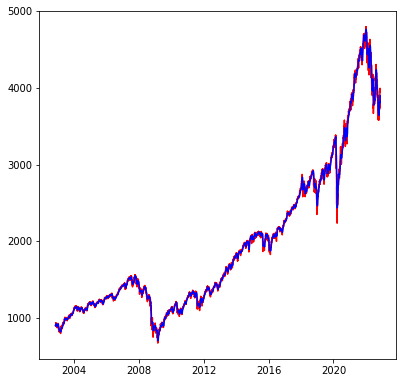

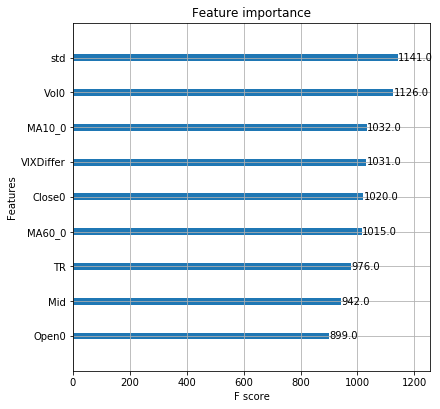

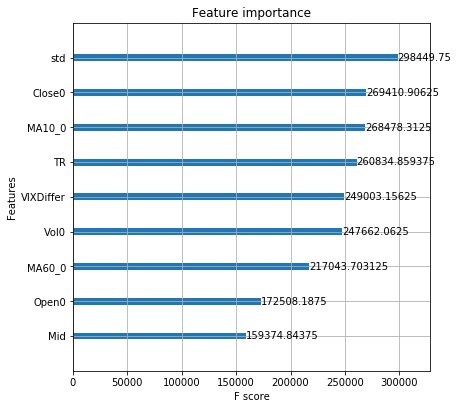

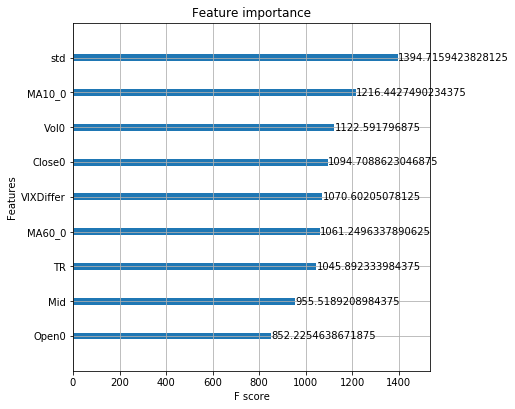

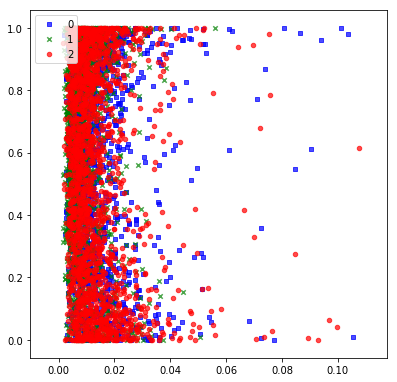

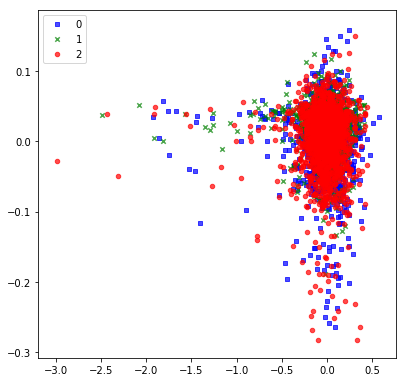

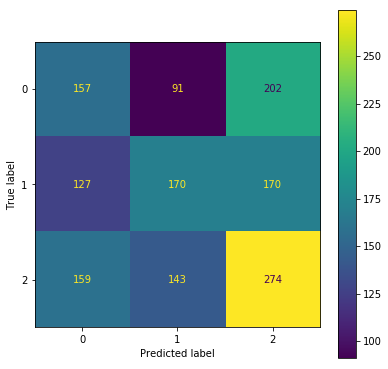

In [12]:
# y
df['up']= df['diff'].apply(lambda x: 2 if x>0.0025 else (0 if x<-0.0025 else 1 ))
print('漲: ',len(df.loc[df['up'] == 2]), '\n平: ',len(df.loc[df['up'] == 1]), '\n跌: ',len(df.loc[df['up'] == 0]))

plt.plot(df['Close'],color="red", label='Close')
plt.plot(df['MA10'],color="blue", label='MA60')

df=df[:-1]

X=df[['VIXDiffer','std','Close0', 'Mid','Vol0' , 'MA10_0' , 'MA60_0' , 'TR' , 'Open0']]
y=df[['up']]

X = X[61:]
y = y[61:]

#
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, shuffle=False)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(booster='gbtree', objective='multi:softprob')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_xgb = model.predict_proba(X_test)#[:, 1]
accuracy = accuracy_score(y_test, y_pred )

print("Accuracy: %.2f%%" % (accuracy * 100.0))

print('訓練集 Accuracy: ',model.score(X_train,y_train))
print('測試集 Accuracy: ',model.score(X_test,y_test))

from xgboost import plot_importance
plot_importance(model)
plot_importance(model, importance_type='total_cover')
plot_importance(model, importance_type='total_gain')

print('特徵重要程度: ',model.feature_importances_)

from mlxtend.plotting import category_scatter

fig1 = category_scatter(x='TR', y='Mid', label_col='up', 
                       data=df, legend_loc='upper left')

fig2 = category_scatter(x='Vol0' , y='MA60_0', label_col='up', 
                       data=df, legend_loc='upper left')

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

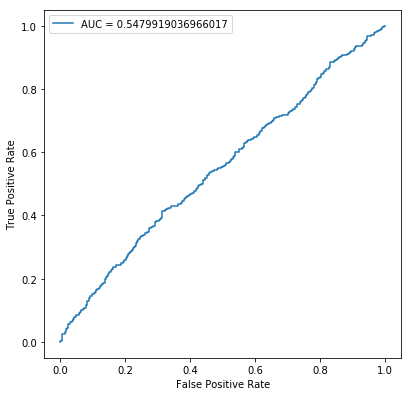

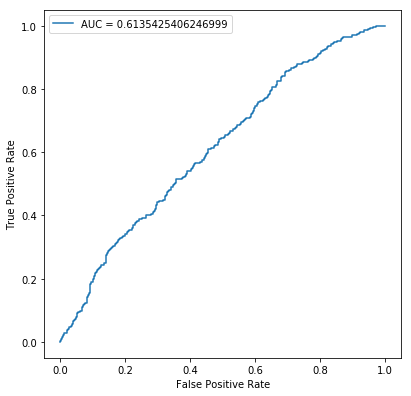

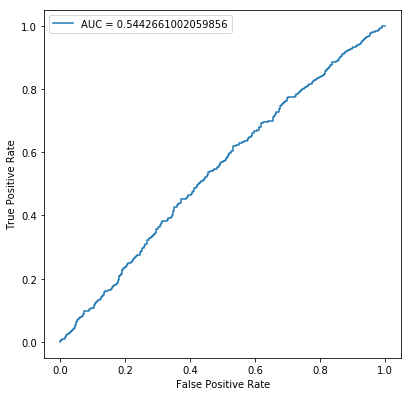

In [13]:
'''
columns_list=list(X.columns)
count=1
plt.subplots(4, 2, figsize=(10, 20))
for i in range(len(columns_list) -1):
    for j in range(i+1, len(columns_list)):
          plt.subplot(4,2,count)
          plt.scatter(x=df.loc[df['up'] == 0][columns_list[i]] , y=df.loc[df['up']==0][columns_list[j]], label='0'
                       ,s=2,color='r')
          plt.scatter(x=df.loc[df['up'] == 1][columns_list[i]] , y=df.loc[df['up']==1][columns_list[j]], label='1'
                       ,s=2,color='g')
          plt.scatter(x=df.loc[df['up'] == 2][columns_list[i]] , y=df.loc[df['up']==2][columns_list[j]], label='2'
                       ,s=2,color='b')
          plt.xlabel(columns_list[i])
          plt.ylabel(columns_list[j])
          plt.tight_layout()
          count+=1
'''
preds = model.predict_proba(X_test)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_test = label_binarize(y_test, classes=[0,1,2])
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], preds[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'AUC = {roc_auc[i]}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.legend()
    plt.show()

2049.5400390625


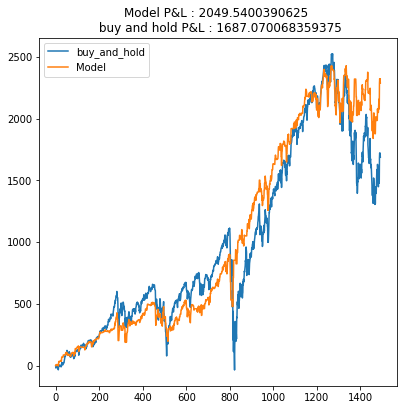

In [14]:
df1 = df[-len(y_pred):].reset_index()
df1['check'] = y_pred
df1['income'] = df1['Close'] - df1['Close'].shift()

buy = False
income_statement = []
for i in range(len(df1)):
    if df1.iloc[i]['check'] == 2 and buy == False:
        stock = df1.iloc[i]['Close']
        buy = True
    if df1.iloc[i]['check'] == 0 and buy == True:
        income_statement.append(df1.iloc[i]['Close'] - stock )
        buy = False
        
buy = False
df1['principal'] = 0
df1['buy_and_hold'] = 0
for i in range(len(df1)-1):
    if df1.iloc[i]['check'] == 2 and buy == False:
        df1.loc[i+1,'principal'] = df1.iloc[i]['principal'] + df1.iloc[i+1]['income']
        buy = True
    
    elif df1.iloc[i]['check'] == 0 and buy == True:
        df1.loc[i+1,'principal'] = df1.iloc[i]['principal']
        buy = False
    
    elif (df1.iloc[i]['check'] == 1 and buy == True) or (df1.iloc[i]['check'] == 2 and buy == True):
        df1.loc[i+1,'principal'] = df1.iloc[i]['principal'] + df1.iloc[i+1]['income']
    else:
        df1.loc[i+1,'principal'] = df1.iloc[i]['principal']
    
    df1.loc[i+1, 'buy_and_hold'] = df1.iloc[i]['buy_and_hold'] + df1.iloc[i+1]['income']
    
plt.rcParams['figure.figsize']=(6.4,6.4)

plt.plot(df1['buy_and_hold'], label='buy_and_hold')
plt.plot(df1['principal'], label='Model')
plt.title(f'Model P&L : {sum(income_statement)} \n buy and hold P&L : {df1.iloc[-1]["buy_and_hold"]}')
plt.legend()
print(sum(income_statement))